In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import matplotlib.pyplot as plt

In [30]:
class SqueezeCell(nn.Module):
    def __init__(self,alpha,input_channels,growth_rate,g,stride1):
        super(SqueezeCell,self).__init__()
        temp_channels = int(growth_rate*alpha)
        #print(temp_channels)
        #print(growth_rate)
        self.conv1 = nn.Conv2d(input_channels,temp_channels,kernel_size=1,stride=1)
        self.groupconv = nn.Conv2d(temp_channels,int(growth_rate),kernel_size=3,stride=stride1,groups=g,padding=1)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.groupconv(x)
        return x,x,x,x


In [31]:
class MECell(nn.Module):
    def __init__(self, input_channels):
        super(MECell,self).__init__()
        self.conv1 = nn.Conv2d(input_channels,input_channels,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(input_channels,input_channels,kernel_size=5,stride=1,padding=2)
        
    def forward(self,x1,x2):
        out1 = self.conv1(x1)
        out2 = self.conv2(x2)
        return out1,out2

In [32]:
#更新门中x1和x2分别代表MECell中的3x3和5x5
class Update_Gate(nn.Module):
    def __init__(self,input_channels,ru):
        super(Update_Gate,self).__init__()
        self.block = nn.Sequential(nn.Conv2d(input_channels,1,kernel_size=1,stride=1),
                                   nn.Softmax(dim=2),
                                   )
        self.input = input_channels
        self.temp = int(2*self.input/ru)
        self.fc1 = nn.Linear(2*self.input,self.temp)
        self.bn1 = nn.BatchNorm2d(self.temp)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(self.temp,self.input)
        
    def forward(self,x1,x2):
        #分别将x1和x2喂入块
        x3 = self.block(x1)
        x4 = self.block(x2)
        #全局注意力池化
        x3 = torch.sum(x1*x3,dim=2,keepdim=True)
        x3 = torch.sum(x3,dim=3,keepdim=True)
        #全局注意力池化
        x4 = torch.sum(x2*x4,dim=2,keepdim=True)
        x4 = torch.sum(x4,dim=3,keepdim=True)
        #拼接
        x5 = torch.cat((x3,x4),dim=1)
        #print(x5.shape)
        x5 = x5.view(x5.shape[0],2*self.input)
        x5 = self.fc1(x5)
        x5 = x5.view(x5.shape[0],self.temp,1,1)
        x5 = self.bn1(x5)
        x5 = self.tanh(x5)
        
        x5 = x5.view(x5.shape[0],self.temp)
        
        x6 = self.fc2(x5)
        x7 = self.fc2(x5)
        
        x6 = x6.view(x6.shape[0],self.input,1,1)
        x7 = x7.view(x7.shape[0],self.input,1,1)
        
        sum = torch.exp(x6)+torch.exp(x7)
        x8 = torch.exp(x6)/sum
        x9 = torch.exp(x7)/sum
        x8 = x3*x8
        x9 = x4*x9
        out = x8+x9
        return out

In [33]:
class Forget_Gate(nn.Module):
    def __init__(self,input_channels,rf):
        super(Forget_Gate,self).__init__()
        self.block = nn.Sequential(nn.Conv2d(input_channels,1,kernel_size=1,stride=1),
                           nn.Softmax(dim=2),
                           )
        self.input = input_channels
        self.temp = int(self.input/rf)
        #print(self.input)
        #print(self.temp)
        self.fc1 = nn.Linear(self.input,self.temp)
        self.bn1 = nn.BatchNorm2d(self.temp)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(self.temp,self.input)
        self.sig = nn.Sigmoid()
        
    def forward(self,x):
        x1 = self.block(x)
        x2 = torch.sum(x*x1,dim=2,keepdim=True)
        x2 = torch.sum(x2,dim=3,keepdim=True)
        #print(x2.shape)
        x2 = x2.view(x2.shape[0],self.input)
        x3 = self.fc1(x2)
        x3 = x3.view(x2.shape[0],self.temp,1,1)
        x4 = self.bn1(x3)
        x5 = self.tanh(x4)
        x5 = x5.view(x5.shape[0],self.temp)
        x6 = self.fc2(x5)
        x6 = x6.view(x6.shape[0],self.input,1,1)
        out = self.sig(x6)
        return out

In [34]:
class SMG(nn.Module):
    def __init__(self,input_channels,output_channels,alpha,g,ru,rf,S):
        super(SMG,self).__init__()
        self.sc = SqueezeCell(alpha,input_channels,output_channels,g,S)
        self.mc = MECell(output_channels)
        self.ug = Update_Gate(output_channels,ru)
        self.fg = Forget_Gate(output_channels,rf)
    
    def forward(self,x):
        x1,x2,x3,x4 = self.sc(x)
        x2 = self.fg(x2)
        #print(x2.shape)
        out1 = x1*x2
        
        temp1,temp2 = self.mc(x3,x4)
        out2 = self.ug(temp1,temp2)
        
        out = out1+out2
        return out


In [35]:
class CBR(nn.Module):
    def __init__(self,input_channels,output_channels):
        super(CBR,self).__init__()
        self.block = nn.Sequential(nn.Conv2d(input_channels,output_channels,kernel_size=3,stride=1),
                                   nn.BatchNorm2d(output_channels),
                                   nn.ReLU(),
                                   )
    
    def forward(self,x):
        x = self.block(x)
        return x

In [36]:
class stem(nn.Module):
    def __init__(self,input_channels,growth_rate):
        super(stem,self).__init__()
        self.block1 = CBR(input_channels,growth_rate*2)
        self.block2 = CBR(growth_rate*2,growth_rate*2*2)
        self.block3 = CBR(growth_rate*2*2,growth_rate*2*2*2)
        self.pool = nn.MaxPool2d(3,2)
        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.pool(x)
        return x

In [37]:
class Hybrid_Block(nn.Module):
    def __init__(self,input_channels,smg_num,growth_rate,alpha=4,g=2,ru=2,rf=2,S=1):
        super(Hybrid_Block,self).__init__()
        self.smglist = nn.ModuleList()
        for i in range(smg_num):
            if i>1:
                self.smg = SMG(input_channels+growth_rate*(i-1),growth_rate,alpha,g,ru,rf,S)
            else:
                self.smg = SMG(input_channels,growth_rate,alpha,g,ru,rf,S)
            self.smglist.append(self.smg)
    
    def forward(self,x):
        for i in range(len(self.smglist)):
            temp = self.smglist[i](x)
            #print(x.shape)
            #print(x.shape)
            #print(temp.shape)
            if i>0:
                x = torch.cat((x,temp),dim=1)
        return x

In [38]:
class Transition(nn.Module):
    def __init__(self,input_channels,growth_rate,theta=0.5,alpha=1.5,g=1,ru=4,rf=4,S=2):
        super(Transition,self).__init__()
        self.smg = SMG(input_channels,int(input_channels*theta),alpha,g,ru,rf,S)
    
    def forward(self,x):
        x = self.smg(x)
        return x

In [39]:
class HCGNet(nn.Module):
    def __init__(self,Hnum,growth_rate,num_classes=1000):
        super(HCGNet,self).__init__()
        self.input_channels = (growth_rate[0])*8
        self.stem = stem(3,growth_rate[0])
        nums = len(Hnum)
        self.Hblock = nn.ModuleList()
        theta = 0.5
        for i in range(nums):
            self.Hblock.append(Hybrid_Block(self.input_channels,Hnum[i],growth_rate[i]))
            self.input_channels += (Hnum[i]-1)*growth_rate[i]
            if i==nums-1:
                break;
            self.Hblock.append(Transition(self.input_channels,growth_rate[i],theta=0.5))
            self.input_channels = int(self.input_channels*theta)
        self.avgpool = nn.AvgPool2d(2,2)
        self.fc1 = nn.Linear(self.input_channels,num_classes)
        
    def forward(self,x):
        x = self.stem(x)
        for i in range(len(self.Hblock)):
            x = self.Hblock[i](x)
        x = self.avgpool(x)
        #print(x.shape)
        x = x.view(x.shape[0],x.shape[1])
        x = self.fc1(x)
        return x

In [41]:
Hnum = [8,8,8]
growth_rate = [12,24,36]
model = HCGNet(Hnum,growth_rate)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device)

cuda:0


HCGNet(
  (stem): stem(
    (block1): CBR(
      (block): Sequential(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (block2): CBR(
      (block): Sequential(
        (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (block3): CBR(
      (block): Sequential(
        (0): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Hblock): ModuleList(
    (0): Hybrid_Block(
      (smglist): ModuleList(
        (0): SMG(
          (sc): SqueezeCell(
            (conv1): Conv2d(96, 48, kernel_size=(1, 1),

In [44]:
import torchvision.transforms as transforms
num_classes = 10
trainset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True, download=True,
                                        transform=transforms.Compose([
                                         transforms.RandomCrop(32, padding=4),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.49139968, 0.48215827, 0.44653124],
                                                              [0.24703233, 0.24348505, 0.26158768])
                                        ]))
testset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False, download=True,
                                       transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.49139968, 0.48215827, 0.44653124],
                                                             [0.24703233, 0.24348505, 0.26158768]),]))
trainloader = DataLoader(trainset,batch_size=128,num_workers=2)
testloader = DataLoader(testset,batch_size=128,num_workers=2)
optimizer = torch.optim.SGD(model.parameters(),lr=1e-4,momentum=0.9)
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [50]:
from tqdm import tqdm
#model = torch.load('HCGNet.pth')
epochs = 50
running_loss = 0.0
model.train()
xlist = []
acc = []
losslist = []
for epoch in range(epochs):
    total_loss = 0
    total_corr = 0
    total_size = 0
    bar1 = tqdm(trainloader)
    for images,labels in bar1:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output,labels)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            _,predicted = torch.max(output,1)
            running_loss = loss
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            accuracy = correct/total
            bar1.set_description("Batch: {}  loss: {:.3f}  accuracy: {:.3f}%".format(epoch+1,running_loss,accuracy*100))
    
            total_corr += correct
            total_loss += running_loss.item()
            total_size += total

    xlist.append(epoch+1)
    acc.append(total_corr/total_size)
    losslist.append(total_loss/128)
      
torch.save(model,'HCGNet.pth')

Batch: 50  loss: 0.877  accuracy: 68.750%: 100%|██████████| 391/391 [00:53<00:00,  7.30it/s]


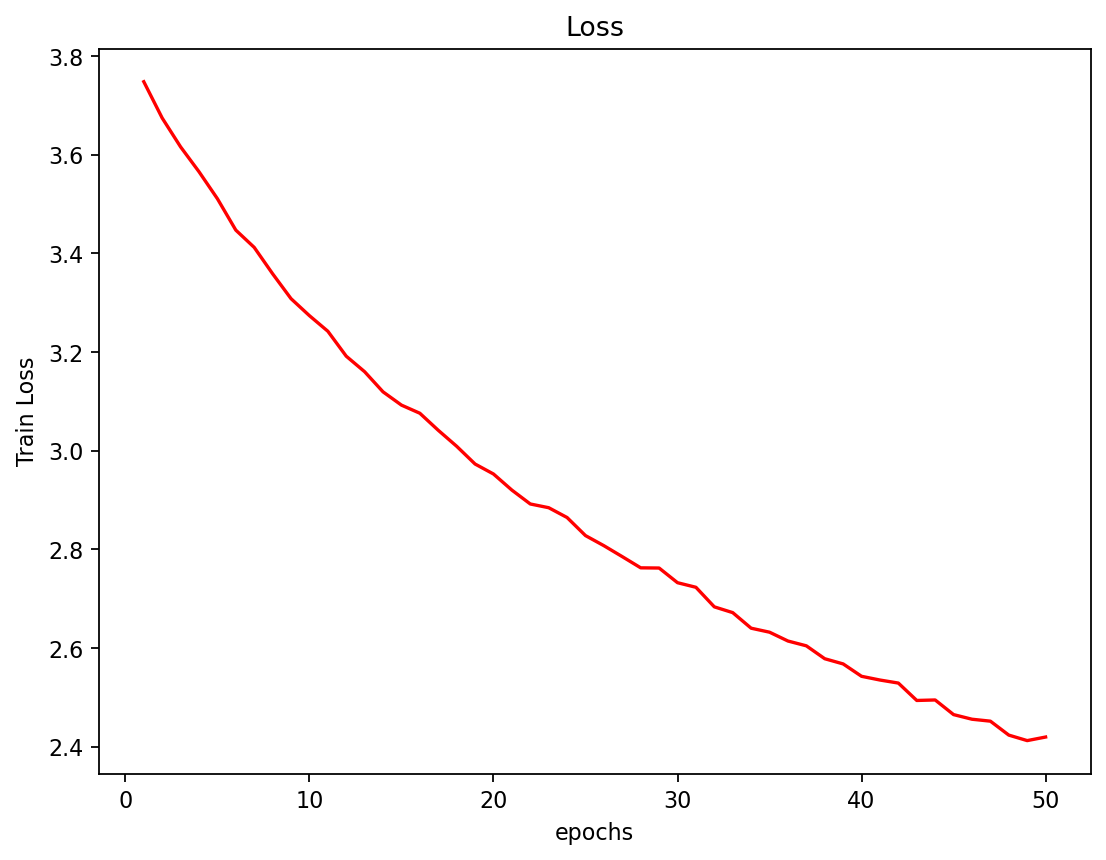

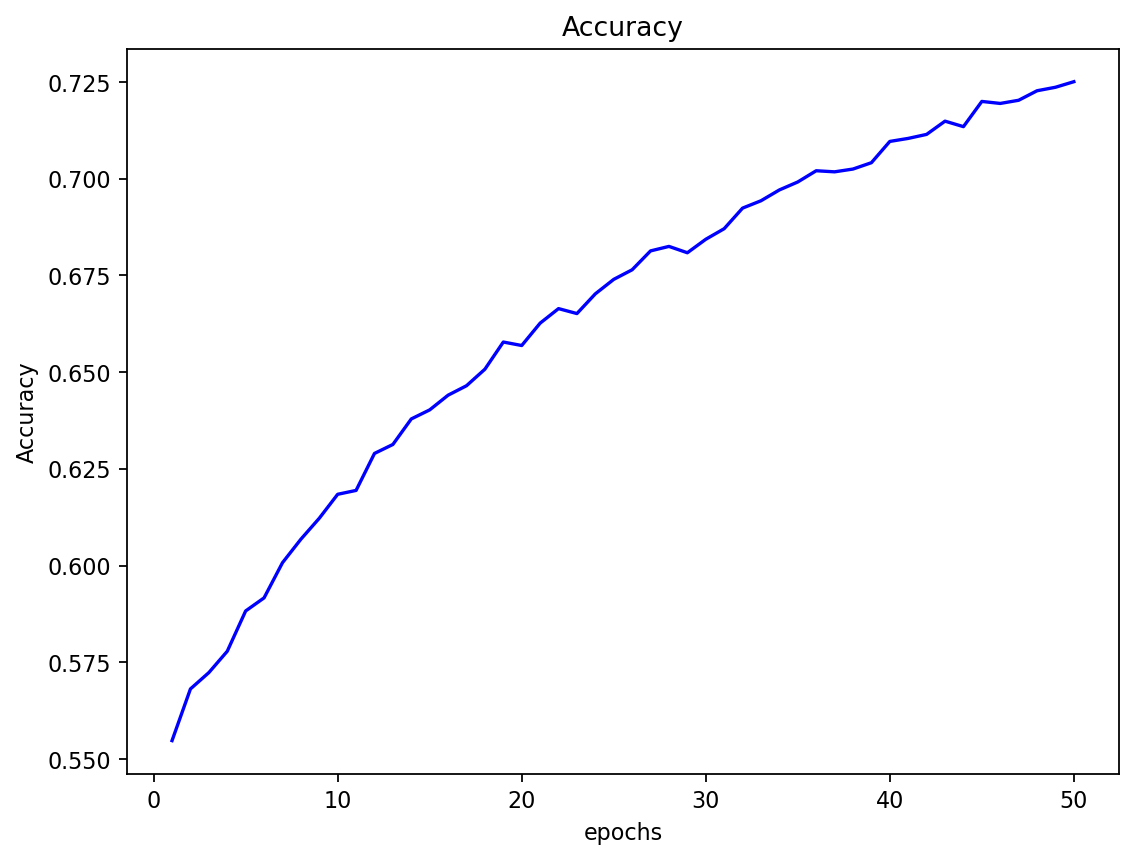

In [51]:
# 设置图片大小和分辨率
fig=plt.figure(figsize=(8, 6), dpi=160)
# 绘制折线图
plt.plot(xlist, losslist, label='Loss',color='r')
# 描述内容信息
plt.xlabel("epochs")  # x轴
plt.ylabel("Train Loss")  # y轴
plt.title("Loss")
plt.savefig("Loss.png")  # 保存在当前目录中

# 设置图片大小和分辨率
fig=plt.figure(figsize=(8, 6), dpi=160)
#设置横坐标范围，这里要与上面a1中的数据个数相对应
#plt.ylim([0.2, 7])#设置y轴显示范围从0.8到1
# 绘制折线图
plt.plot(xlist, acc, label='Accuracy',color='b')
# 描述内容信息
plt.xlabel("epochs")  # x轴
plt.ylabel("Accuracy")  # y轴
plt.title("Accuracy")
plt.savefig("Acc.png")  # 保存在当前目录中  